<center style="font-weight:bold;font-size:26px">Pericolo - Marker Generation </center>

# Setup

## Imports

In [1]:
import os
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from cv2 import aruco
import pandas as pd
from skimage import feature, color, transform, io
from scipy.spatial import distance as dist
from PIL import Image, ImageDraw

In [3]:
sys.path.append(os.path.join(os.path.abspath(''), '.'))

## Global Variables

In [4]:
ROOT_FOLDER = os.path.join(os.path.abspath(''), '..')
DATA_FOLDER = os.path.join(ROOT_FOLDER, 'data')
IMG_FOLDER = os.path.join(DATA_FOLDER, 'img')
ANNOT_FOLDER = os.path.join(DATA_FOLDER, 'annotations')

# Functions definition

## Plot functions

In [5]:
def imshow(img, figsize=(6, 6), cmap=None):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap)
    plt.show()

In [6]:
def imshow_masked(img, mask, figsize=(6,6), factor=0.3):
    fig = plt.figure(figsize=figsize)
    aux_img = img.astype(float)
    aux_mask = np.expand_dims(mask.astype(float)*(1-factor) + factor, axis=-1)
    drk_img = (aux_img * aux_mask).astype(np.uint8)
    plt.imshow(drk_img)
    plt.show()

# Aruco Generation

## Aruco Board

We first generate an Aruco Board as described in [Aruco Basics for OpenCV Python](https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/aruco_basics.html)

In [5]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

You can tweak `nx` and `ny` to generate an Aruco Board with marker's id ranging from `0` to `nx*ny`

To control markers are genuine you can use [Aruco Generator](http://chev.me/arucogen/) to confirm id are matching

Please note that, on the next cell, marker's id range from `1` to `nx*ny+1`

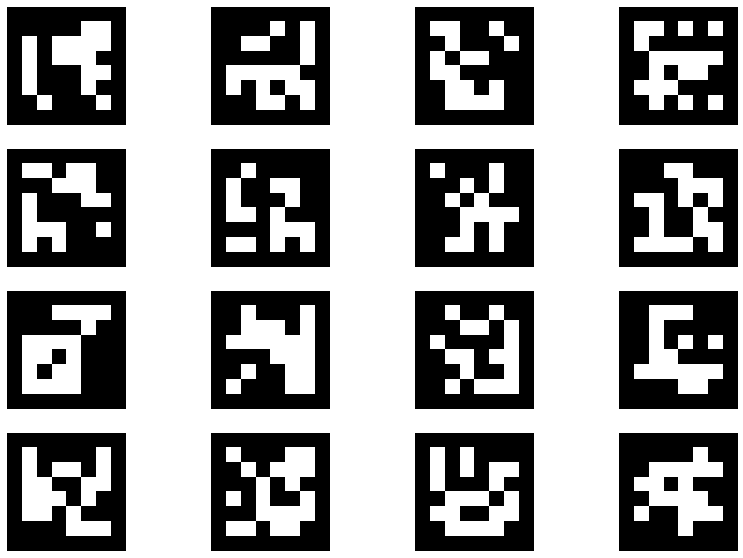

In [6]:
# The figsize is (14, 10) to match as closely as possible the A4 format ratio (29.7/21 ~ 1.41)
fig = plt.figure(figsize=(14, 10))
nx = 4
ny = 4
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i, 700)
    plt.imshow(img, cmap = 'gray', interpolation = "nearest")
    ax.axis("off")

plt.savefig("aruco_board.pdf")
plt.savefig("aruco_board.png")
plt.show()

Since we have Aruco markers, we'll try to enhance the board with black borders to allow sift detector to detect the entire page _(A4 format $21\cdot29.7\;cm^2$)_

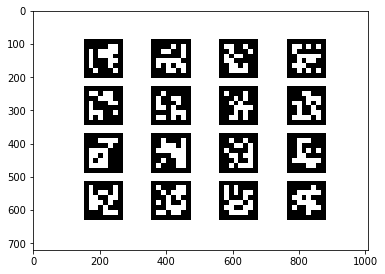

In [11]:
aruco_board = io.imread("aruco_board.png")
imshow(aruco_board)

We generate black borders thanks to the 4 following variables.
- `padding_[h|v]` to apply an horizontal/vertical offset to the black borders
- `size_[h|v]` to define the thickness of the horizontal/vertical borders

The default values used in the Aruco Board Notebook are:
- `padding_h = 0`
- `padding_v = 0`
- `size_h = 20`
- `size_v = 50`

In [12]:
# We generate black borders thanks to the 4 following variables.
# Padding to apply an offset to the black borders
# Size to define the thickness of the borders
padding_h = 0
padding_v = 0
size_h = 20
size_v = 50

The generated board is ready to be printed. Use lanscape orientation and allow printer margin.

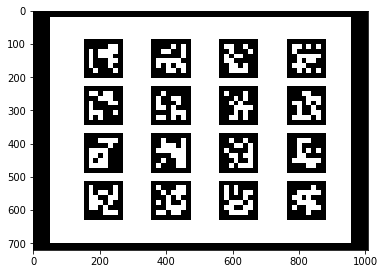

In [13]:
shape = aruco_board.shape
new_img = aruco_board[:, :, :3].copy()
# Horizontal Lines
new_img[padding_h:padding_h+size_h, padding_v:shape[1]-padding_v, :] = 0
new_img[shape[0]-padding_h-size_h:shape[0]-padding_h, padding_v:shape[1]-padding_v, :] = 0
# Vertical Lines
new_img[padding_h:shape[0]-padding_h ,padding_v:padding_v+size_v, :] = 0
new_img[padding_h:shape[0]-padding_h, shape[1]-padding_v-size_v:shape[1]-padding_v, :] = 0
imshow(new_img[:,:, :3])
io.imsave("aruco_board_w_borders.png", new_img[:, :, :3])

Since the printed board will obviously have margin from printer, we generate virtually the white borders for a better detection by the SIFT detector.

By default, we use `vstack=30` and `hstack=30`

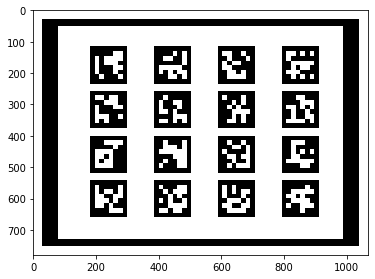

In [14]:
# White border size in pixel
vstack = 30
hstack = 30
# White borders generation
vstacker = 255 * np.ones((vstack, shape[1], 3))
hstacker = 255 * np.ones((shape[0]+2*hstack, hstack, 3))
stacked_img = np.vstack([vstacker, new_img, vstacker])
stacked_img = np.hstack([hstacker, stacked_img, hstacker])
stacked_img = stacked_img.astype(np.uint8)
imshow(stacked_img)
io.imsave("aruco_board_w_borders_sift.png", stacked_img)

You have now generated the board to be printed and the one to be used as training board for SIFT detectors

## Single Marker generation

We generate a single marker with large dimension to create our own enclosed marker

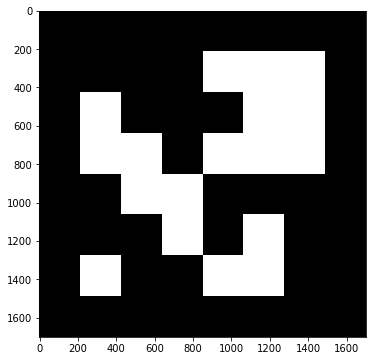

In [15]:
single_aruco_marker = aruco.drawMarker(aruco_dict, 0, 1700)
imshow(single_aruco_marker, cmap='gray')
io.imsave("single_aruco_marker.png", single_aruco_marker)

Since we generate a single marker with a genuine ID, we now modify the enclosed marker found in [ArUco Library Documentation
](https://docs.google.com/document/d/1QU9KoBtjSM2kF6ITOjQ76xqL7H0TEtXriJX5kwi9Kgc/edit#).

The enclosed marker was modified with a image editing software _(Gimp)_ for the sake of time, but results as the following marker:
![enclosed_marker](../markers/single_aruco_marker_enclosed_id0.png)

We can create a function that generates enclosed marker.

In [16]:
def generate_enclosed_marker(aruco_dict, marker_id, marker_size, square_factor=4):
    aruco_marker = aruco.drawMarker(aruco_dict,marker_id, marker_size)
    offset = marker_size // square_factor
    h_stack = 255*np.ones((marker_size, offset))
    v_stack = 255*np.ones(( offset, marker_size+2*offset))
    aruco_marker = np.hstack([h_stack, aruco_marker, h_stack])
    aruco_marker = np.vstack([v_stack, aruco_marker, v_stack])
    aruco_marker[0:offset, 0:offset] = 0
    aruco_marker[marker_size+offset:marker_size+2*offset, 0:offset] = 0
    aruco_marker[0:offset, marker_size+offset:marker_size+2*offset] = 0
    aruco_marker[marker_size+offset:marker_size+2*offset, marker_size+offset:marker_size+2*offset] = 0
    aruco_marker[marker_size+offset:marker_size+2*offset, 0:offset] = 0
    return aruco_marker

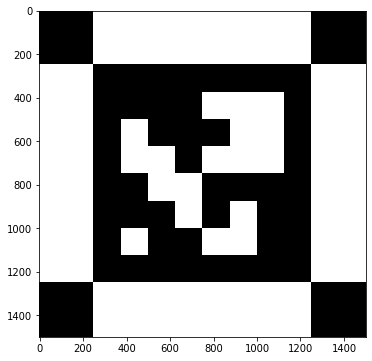

In [17]:
imshow(generate_enclosed_marker(0, 1000), cmap='gray')

# Investigation on Unknown Marker

Support on [Aruco dictionnaries](https://docs.opencv.org/trunk/d5/dae/tutorial_aruco_detection.html)

In [7]:
def image_to_tile(im, tile_size=8):
    M = im.shape[0]//tile_size
    N = im.shape[1]//tile_size
    tiles = [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)]
    return tiles

In [8]:
def tiles_profile(tiles, tile_size=8):
    medians = list(map(lambda x: np.median(x),tiles))
    medians = np.array(medians) // 255
    medians = medians.reshape((tile_size, tile_size))
    return medians

We generate the profile of a marker by dividing it into $8\times8$ tiles. A $0$ meaning black tile and $1$ meaning white tile.

We will use 2 aproach to find the unknown marker ID.
- Compare the profile to find the exact same one as the unknow marker
- Try to find the marker id that minimize the absolute error with regard to the unknown marker

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


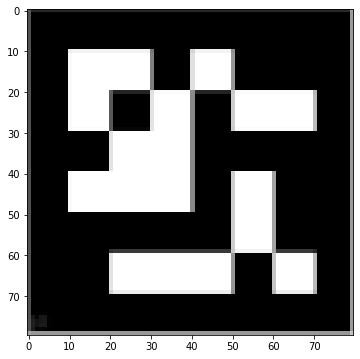

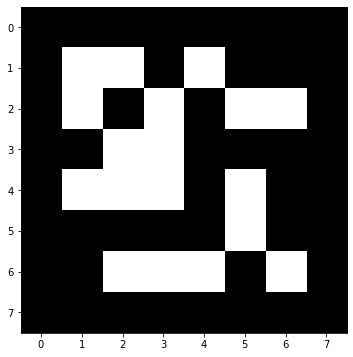

In [29]:
# We open a Marker Image
unknown_marker = cv2.imread(os.path.join(ROOT_FOLDER, 'markers', 'unknown_marker.png'),0)
#unknown_marker = cv2.imread(os.path.join(ROOT_FOLDER, 'markers', 'single_aruco_marker_id0.png'),0)
#unknown_marker = cv2.rotate(unknown_marker, cv2.ROTATE_180)
# We resize the marker image to (80,80)
unknown_marker = cv2.resize(unknown_marker, (80,80))
# We split the image into 8X8 tiles
tiles = image_to_tile(unknown_marker)
# For each tile we compute the median to find the dominant color (black or white)
tiled_img = tiles_profile(tiles)
print(tiled_img)
imshow(unknown_marker, cmap='gray')
imshow(tiled_img, cmap='gray')

The biggest Aruco dictionnary available in OpenCV-Python is the `DICT_6X6_1000` containing 1000 markers. We loop over each possible IDs [0-999] to compare their profile to the unknown marker.

In [25]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_1000)

In [26]:
# Check for exact match
for i in range(1000):
    aux_marker = aruco.drawMarker(aruco_dict, i, 80)
    aux_tiles = image_to_tile(aux_marker)
    tiled_aux = tiles_profile(aux_tiles)
    if np.array_equal(tiled_aux, tiled_img):
        print(f"$$$$$$ MATCH ID {i} $$$$$$")
        break
    if i % 50 == 0:
        print(f"Step {i+1}/1000")

Step 1/1000
Step 51/1000
Step 101/1000
Step 151/1000
Step 201/1000
Step 251/1000
Step 301/1000
Step 351/1000
Step 401/1000
Step 451/1000
Step 501/1000
Step 551/1000
Step 601/1000
Step 651/1000
Step 701/1000
Step 751/1000
Step 801/1000
Step 851/1000
Step 901/1000
Step 951/1000


No markers seem to match exactly the unknown marker within the whole `DICT_6X6_1000` Aruco dictionnary.

Next, we try to find the closest marker available in the `DICT_6X6_1000`to the unknown marker by computing their profile error.

In [27]:
# Check for minimum error
error = 8*8
for i in range(1000):
    aux_marker = aruco.drawMarker(aruco_dict, i, 80)
    aux_tiles = image_to_tile(aux_marker)
    tiled_aux = tiles_profile(aux_tiles)
    aux_error = np.abs(tiled_aux - tiled_img).sum()
    if aux_error < error:
        print(f"Minimum Error found for id {i} with {aux_error}")
        error = aux_error
        top_index = i

Minimum Error found for id 0 with 18.0
Minimum Error found for id 2 with 16.0
Minimum Error found for id 6 with 12.0
Minimum Error found for id 35 with 11.0
Minimum Error found for id 238 with 8.0


It seems the closest marker found in term of error has nothing to do with the unknown marker. So far, we are not able to determine any specific ID for this unknown marker. It appears it is not contained in the pre-defined Aruco dictionnaries, meaning the Aruco function `detectMarkers` will not be able to find this unknown marker on a scene since it relies on Aruco dictionnaries.

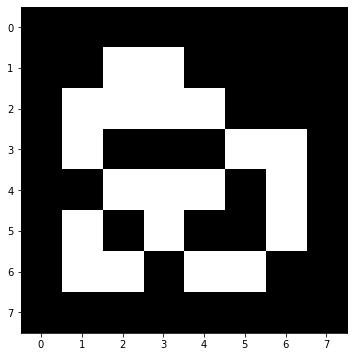

In [28]:
imshow(aruco.drawMarker(aruco_dict, top_index, 8), cmap='gray')